In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Bidirectional, Dense
import tensorflow as tf
import os
from timeit import default_timer as timer

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  


In [20]:
# Load the dataset
weather_data = pd.read_csv("../austin_weather.csv")

# Display the first few rows of the dataset
print(weather_data.head())

         Date  TempHighF  TempAvgF  TempLowF DewPointHighF DewPointAvgF  \
0  2013-12-21         74        60        45            67           49   
1  2013-12-22         56        48        39            43           36   
2  2013-12-23         58        45        32            31           27   
3  2013-12-24         61        46        31            36           28   
4  2013-12-25         58        50        41            44           40   

  DewPointLowF HumidityHighPercent HumidityAvgPercent HumidityLowPercent  ...  \
0           43                  93                 75                 57  ...   
1           28                  93                 68                 43  ...   
2           23                  76                 52                 27  ...   
3           21                  89                 56                 22  ...   
4           36                  86                 71                 56  ...   

  SeaLevelPressureAvgInches SeaLevelPressureLowInches Visibili

In [21]:
# Extract the 'TempAvgF' column as a time series
temperature_series = weather_data['TempAvgF'].values.astype(float)

print(len(temperature_series))
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_series_scaled = scaler.fit_transform(temperature_series.reshape(-1, 1))

1319


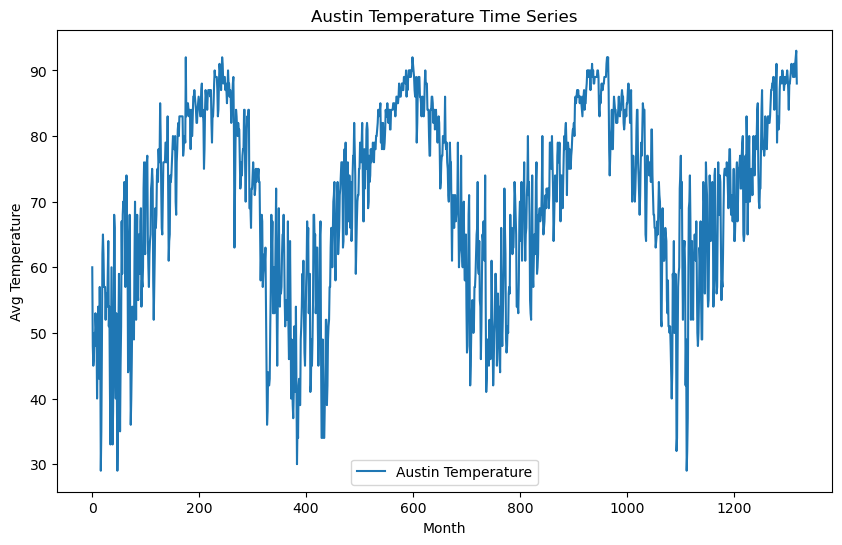

In [22]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(temperature_series, label='Austin Temperature')
plt.title('Austin Temperature Time Series')
plt.xlabel('Month')
plt.ylabel('Avg Temperature')
plt.legend()
plt.show()

In [23]:
# Function to create the dataset with input features and labels
def create_dataset(series, look_back=1):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:(i + look_back), 0])
        y.append(series[i + look_back, 0])
    return np.array(X), np.array(y)

In [24]:
look_back = 7  # You can experiment with different values
X, y = create_dataset(temperature_series_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train)

[[[0.484375]
  [0.296875]
  [0.25    ]
  ...
  [0.328125]
  [0.296875]
  [0.375   ]]

 [[0.296875]
  [0.25    ]
  [0.265625]
  ...
  [0.296875]
  [0.375   ]
  [0.34375 ]]

 [[0.25    ]
  [0.265625]
  [0.328125]
  ...
  [0.375   ]
  [0.34375 ]
  [0.328125]]

 ...

 [[0.8125  ]
  [0.8125  ]
  [0.703125]
  ...
  [0.609375]
  [0.609375]
  [0.578125]]

 [[0.8125  ]
  [0.703125]
  [0.65625 ]
  ...
  [0.609375]
  [0.578125]
  [0.578125]]

 [[0.703125]
  [0.65625 ]
  [0.609375]
  ...
  [0.578125]
  [0.578125]
  [0.53125 ]]]


In [25]:
mse = []
mae = []  
rmse = []
r2 = []
class PredictionCallback(tf.keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(X_test)
    

    # Evaluate the model on training and testing data
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    rmse.append(test_rmse)
    mse.append(metrics.mean_squared_error(y_test, y_pred))
    mae.append((metrics.mean_absolute_error(y_test, y_pred)))
    r2.append(metrics.r2_score(y_test, y_pred))



In [26]:
class Model_Timer(tf.keras.callbacks.Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [27]:
model = Sequential([
    Bidirectional(SimpleRNN(units=50, return_sequences=True, input_shape=(X.shape[1], 1))),
    Bidirectional(SimpleRNN(units=50,return_sequences=True)),
    Bidirectional(SimpleRNN(units=50, return_sequences=True)),
    Bidirectional(SimpleRNN(units=50)),
    Dense(units=1)
])

cb = Model_Timer()
# Compile the model
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), loss="mse", metrics=["MeanAbsoluteError","RootMeanSquaredError", "MeanSquaredError"])
model.fit(X_train, y_train, batch_size=8, epochs=25, validation_data=(X_test, y_test),callbacks=[PredictionCallback(), cb])

Epoch 1/25
132/132 [==============================] - 3s 9ms/step - loss: 0.0615 - mean_absolute_error: 0.1355 - root_mean_squared_error: 0.2480 - mean_squared_error: 0.0615 - val_loss: 0.0095 - val_mean_absolute_error: 0.0730 - val_root_mean_squared_error: 0.0973 - val_mean_squared_error: 0.0095
Epoch 2/25
132/132 [==============================] - 1s 5ms/step - loss: 0.0085 - mean_absolute_error: 0.0691 - root_mean_squared_error: 0.0921 - mean_squared_error: 0.0085 - val_loss: 0.0176 - val_mean_absolute_error: 0.1077 - val_root_mean_squared_error: 0.1326 - val_mean_squared_error: 0.0176
Epoch 3/25
132/132 [==============================] - 1s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0739 - root_mean_squared_error: 0.0952 - mean_squared_error: 0.0091 - val_loss: 0.0413 - val_mean_absolute_error: 0.1874 - val_root_mean_squared_error: 0.2031 - val_mean_squared_error: 0.0413
Epoch 4/25
132/132 [==============================] - 1s 5ms/step - loss: 0.0115 - mean_absolute_error: 0.

In [28]:
time_took_to_run = sum(cb.logs)
print(time_took_to_run)

19.58799583464861


In [29]:
# Predict using the trained model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
scaler.inverse_transform(test_predictions.reshape(-1,1))

9/9 [==============================] - 0s 2ms/step


array([[66.4904  ],
       [66.513695],
       [68.03131 ],
       [65.64859 ],
       [69.61996 ],
       [72.10445 ],
       [70.83352 ],
       [71.108536],
       [67.39522 ],
       [49.53275 ],
       [56.04447 ],
       [63.767464],
       [67.81944 ],
       [57.95233 ],
       [61.888954],
       [61.003895],
       [63.208115],
       [67.034424],
       [64.755424],
       [64.70497 ],
       [54.048   ],
       [56.289497],
       [60.454826],
       [47.839302],
       [53.78221 ],
       [51.31095 ],
       [52.93682 ],
       [47.998474],
       [45.456505],
       [42.256927],
       [48.54267 ],
       [56.660294],
       [50.868805],
       [61.237217],
       [44.246384],
       [54.577   ],
       [59.794357],
       [52.168903],
       [21.916773],
       [44.780357],
       [50.16958 ],
       [55.16983 ],
       [52.14142 ],
       [55.950203],
       [66.85944 ],
       [69.70215 ],
       [73.51476 ],
       [67.75735 ],
       [72.86097 ],
       [57.998413],


In [30]:
# Evaluate the model on training and testing data
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
evaluation = model.evaluate(X_test, y_test)
print(f'Training RMSE: {train_rmse}')
print("Testing RMSE: " + str(evaluation[2]))
print("MSE (validation): " + str(evaluation[0]))
print("MAE (validation): " + str(evaluation[1]))
print("R2 (validation): " + str(r2_score(y_true=y_test, y_pred=test_predictions)))


9/9 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0674 - root_mean_squared_error: 0.0952 - mean_squared_error: 0.0091
Training RMSE: 0.07702517910159724
Testing RMSE: 0.09521841257810593
MSE (validation): 0.009066546335816383
MAE (validation): 0.06739126890897751
R2 (validation): 0.7868515494438537


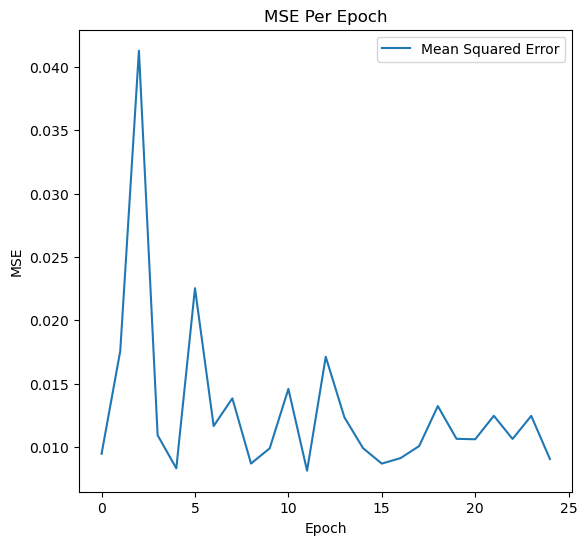

In [31]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(mse, label="Mean Squared Error")
plt.title('MSE Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

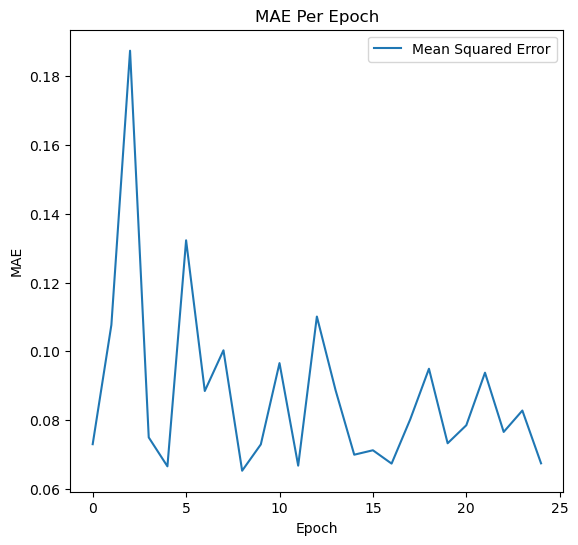

In [32]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(mae, label="Mean Squared Error")
plt.title('MAE Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

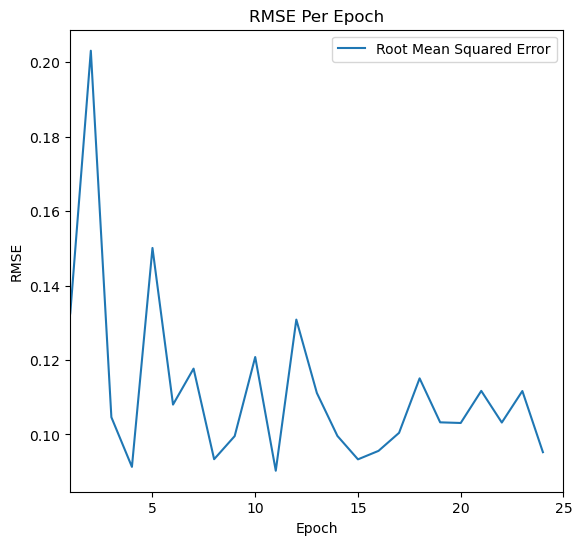

In [33]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(rmse, label="Root Mean Squared Error")
plt.title('RMSE Per Epoch')
plt.xlabel('Epoch')
plt.xlim(1,25)
plt.ylabel('RMSE')
plt.legend()

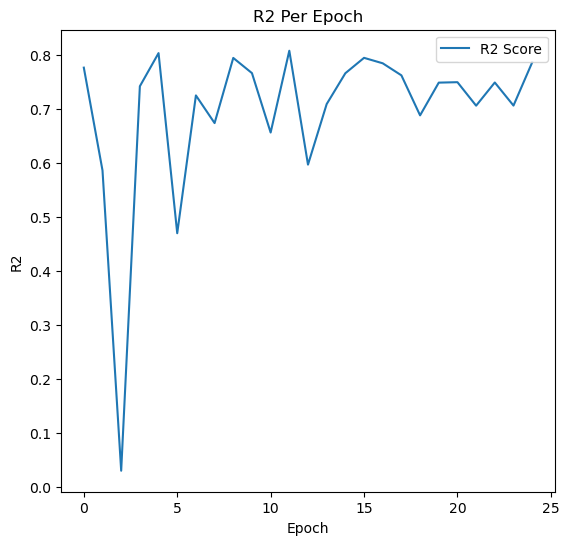

In [34]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(r2, label="R2 Score")
plt.title('R2 Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()

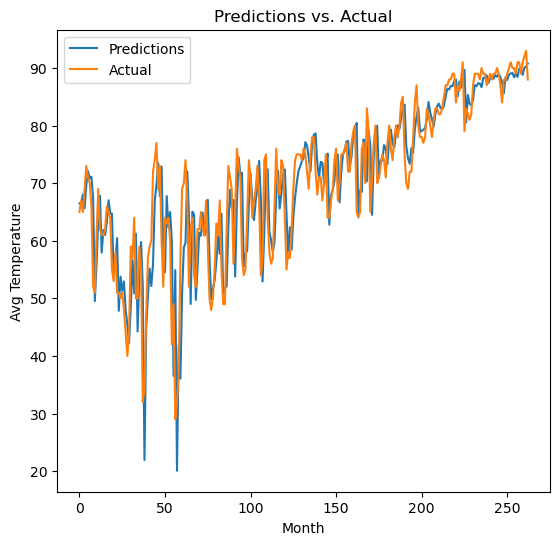

In [35]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(scaler.inverse_transform(test_predictions.reshape(-1,1)), label="Predictions")
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.title('Predictions vs. Actual')
plt.xlabel("Month")
plt.ylabel("Avg Temperature")
plt.legend()
